# Libraries

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/ImageCaptioning

Mounted at /content/drive
/content/drive/MyDrive/ImageCaptioning


In [ ]:
import re
import cv2
import glob
import spacy
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import tensorflow as tf
from collections import Counter
import matplotlib.pyplot as plt


import torch
import torch.nn.functional as F
from torchvision import transforms
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import Dataset, DataLoader
from torchvision.models import resnet50, ResNet50_Weights


device = 'cuda' if torch.cuda.is_available() else 'cpu'


In [ ]:
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 78.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


# Dataset

In [ ]:
spacy_eng = spacy.load("en_core_web_sm")

In [ ]:
class Vocabulary:
    def __init__(self,freq_threshold):
        # Setting the pre-reserved tokens int to string tokens
        self.index2word = {0:"<PAD>", 1:"<SOS>", 2:"<EOS>", 3:"<UNK>"}

        # String to int tokens
        # Tts reverse dict self.index2word
        self.word2index = {v: k for k, v in self.index2word.items()}

        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.index2word)

    @staticmethod
    def tokenize(text):
        return [token.text.lower() for token in spacy_eng.tokenizer(text)]

    def build_vocab(self, sentence_list):
        frequencies = Counter()
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenize(sentence):
                frequencies[word] += 1

                #add the word to the vocab if it reaches minum frequecy threshold
                if frequencies[word] == self.freq_threshold:
                    self.word2index[word] = idx
                    self.index2word[idx] = word
                    idx += 1

    def numericalize(self,text):
        """ For each word in the text corresponding index token for that word form the vocab built as list """
        tokenized_text = self.tokenize(text)
        return [self.word2index[token] if token in self.word2index else self.word2index["<UNK>"] for token in tokenized_text ]

In [ ]:
class ImageCaptioningDataset(Dataset):
    """Image Captioning dataset"""

    def __init__(self, csv_file, transform, freq_threshold=5):
        self.dataframe = pd.read_csv(csv_file)
        self.transform = transform

        self.images = self.dataframe['image']
        self.captions = self.dataframe['caption']

        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocab(self.captions.tolist())


    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        caption = self.captions[idx]
        image_path = self.images[idx]

        image = cv2.imread(f'dataset/Images/{image_path}')
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if self.transform:
            image = self.transform(image)

        caption_vec = []
        caption_vec += [self.vocab.word2index["<SOS>"]]
        caption_vec += self.vocab.numericalize(caption)
        caption_vec += [self.vocab.word2index["<EOS>"]]

        return image, torch.tensor(caption_vec)

# Model

## Image

In [ ]:
class Encoder(torch.nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()

        # Load pretrained model and remove last fc layer
        pretrained_model = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
        self.model = torch.nn.Sequential(*list(pretrained_model.children())[:-2]).to(device)

        # Freeze layer
        for param in self.model.parameters():
            param.requires_grad = False

    def forward(self, images):
        features = self.model(images)                                       # (batch_size, 2048, 7, 7)
        features = features.permute(0, 2, 3, 1)                             # (batch_size, 7, 7, 2048)
        features = features.view(features.size(0), -1, features.size(-1))   # (batch_size, 49, 2048)
        return features

## Attention


In [ ]:
class Attention(torch.nn.Module):
    def __init__(self, attention_dim, encoder_dim, decoder_dim):
        super(Attention, self).__init__()

        self.attention_dim = attention_dim
        self.W_layer = torch.nn.Linear(decoder_dim, attention_dim).to(device)
        self.U_layer = torch.nn.Linear(encoder_dim, attention_dim).to(device)
        self.V_layer = torch.nn.Linear(attention_dim, 1).to(device)

    def forward(self, keys, query):
        U = self.U_layer(keys)     # (batch_size, num_layers, attention_dim)
        W = self.W_layer(query) # (batch_size, attention_dim)

        combined = torch.tanh(U + W.unsqueeze(1)) # (batch_size, num_layers, attention_dim)
        score = self.V_layer(combined)  # (batch_size, num_layers, 1)
        score = score.squeeze(2) # (batch_size, num_layers)

        weights = F.softmax(score, dim=1)    # (batch_size, num_layers)

        context = keys * weights.unsqueeze(2) # (batch_size, num_layers, feature_dim)
        context = context.sum(dim=1)   # (batch_size, feature_dim)
        return context, weights


## Text

In [ ]:
class Decoder(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, attention_dim, encoder_dim, decoder_dim, drop_prob=0.3):
        super(Decoder, self).__init__()
        self.vocab_size = vocab_size

        # Embedding layer
        self.embedding = torch.nn.Embedding(vocab_size, embed_dim)

        # LSTM layer
        self.lstm = torch.nn.LSTMCell(input_size=embed_dim + encoder_dim,
                                      hidden_size=decoder_dim,
                                      bias=True)

        # Linear layer
        self.fcn = torch.nn.Linear(decoder_dim, self.vocab_size)
        self.drop = torch.nn.Dropout(drop_prob)

        # Attention layer
        self.init_h = torch.nn.Linear(encoder_dim, decoder_dim)
        self.init_c = torch.nn.Linear(encoder_dim, decoder_dim)
        self.attention = Attention(attention_dim, encoder_dim, decoder_dim)

    def init_hidden_state(self, features):
        mean_features = features.mean(dim=1)
        h = self.init_h(mean_features)
        c = self.init_c(mean_features)
        return h, c

    def forward_step(self, embed_word, features, hidden_state, cell_state):
        # Computation between features and hidden state to create a context vector
        context, attn_weight = self.attention(features, hidden_state)

        # Compute feature vector of input text
        lstm_input = torch.cat((embed_word, context), dim=1)

        hidden_state, cell_state = self.lstm(lstm_input, (hidden_state, cell_state))

        # Predicted vector
        output = self.fcn(self.drop(hidden_state))
        return output, hidden_state, cell_state, attn_weight

    def forward(self, features, sequences):
        sequence_length = len(sequences[0]) # Sequence length
        preds = torch.zeros(sequences.shape[0], sequence_length, self.vocab_size) # Prediction store

        # Embedding sequence
        embeds = self.embedding(sequences)
        embeds = embeds.to(torch.float32)

        # Init hidden state
        hidden_state, cell_state = self.init_hidden_state(features)

        # Forward pass
        for idx in range(sequence_length):
            embed_word = embeds[:, idx]

            # Predicted vector
            output, hidden_state, cell_state, _ = self.forward_step(embed_word, features, hidden_state, cell_state)

            # Store output
            preds[:, idx] = output

        return preds

    def predict(self, feature, vocab=None, max_length=20):
        word = torch.tensor(vocab.word2index['<SOS>']).view(1, -1) # Starting input
        embeds = self.embedding(word) # Embedding sequence

        captions = []
        attention = []
        hidden_state, cell_state = self.init_hidden_state(feature)

        for idx in range(max_length):
            embed_word = embeds[:, 0]
            output, hidden_state, cell_state, attn_weight = self.forward_step(embed_word, feature, hidden_state, cell_state)
            attention.append(attn_weight.cpu().detach().numpy())

            # Predict word index
            predicted_word_idx = output.argmax(dim=1)
            captions.append(predicted_word_idx.item())

            # End if <EOS> appears
            if vocab.index2word[predicted_word_idx.item()] == "<EOS>":
                break

            # Send generated word as the next caption
            embeds = self.embedding(predicted_word_idx.unsqueeze(0))

        # Convert the vocab idx to words and return sentence
        return ' '.join([vocab.index2word[idx] for idx in captions]), attention

## Captioner

In [ ]:
class Captioner(torch.nn.Module):
    def __init__(self, vocab_size, embed_dim, attention_dim, encoder_dim, decoder_dim, vocab):
        super(Captioner, self).__init__()
        self.image_encoder =  Encoder()
        self.text_decoder = Decoder(vocab_size, embed_dim, attention_dim,
                                                 encoder_dim, decoder_dim)
        self.vocab = vocab

    def forward(self, images, captions):

        features = self.image_encoder(images)
        output = self.text_decoder(features, captions)

        return output

    def generate_caption(self, image, beam_k=1):
        image = image.to(device)
        feature = self.image_encoder(image)
        predicted_caption = self.text_decoder.predict(feature, self.vocab, beam_k)
        return predicted_caption


# Utils

In [ ]:
def get_dataset_loader(batch_size=32):
    transform = transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Resize(232, antialias=True),
                        transforms.CenterCrop(224),
                        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225])])

    dataset = ImageCaptioningDataset(
                        csv_file=f"dataset/captions.txt",
                        transform=transform)

    loader = DataLoader(
                    dataset=dataset,
                    batch_size=batch_size,
                    shuffle=True,
                    num_workers=2,
                    collate_fn=CapsCollate(pad_idx=dataset.vocab.word2index["<PAD>"], batch_first=True))

    return dataset, loader

In [ ]:
# Warmp up GPU and CPU
def cpu():
    random_image = torch.rand(1000, 3, 100, 100)
    net = torch.nn.Conv2d(3, 32, 3)
    _ = net(random_image)

def gpu():
    random_image = torch.rand(1000, 3, 100, 100).to(device)
    net = torch.nn.Conv2d(3, 32, 3).to(device)
    _ = net(random_image)

cpu()
gpu()

In [ ]:
def load_model(path):
    checkpoint = torch.load(path, map_location=torch.device('cpu'))

    model = Captioner(
        vocab_size=checkpoint['vocab_size'],
        embed_dim=checkpoint['embed_dim'],
        attention_dim=checkpoint['attention_dim'],
        encoder_dim=checkpoint['encoder_dim'],
        decoder_dim=checkpoint['decoder_dim'],
        vocab=checkpoint['vocab']
    )
    model.load_state_dict(checkpoint['model_state_dict'])
    return model

def plot_result(image, caption):
    plt.imshow(image)
    plt.axis("off")
    plt.title(caption)

def plot_attention(image, result, attention_plot):
    result = result.split(" ")
    fig = plt.figure(figsize=(15, 15))

    len_result = len(result)
    for l in range(len_result):
        temp_att = attention_plot[l].reshape(7,7)

        ax = fig.add_subplot(len_result // 2,len_result // 2, l+1)
        ax.set_title(result[l])
        ax.set_axis_off()
        img = ax.imshow(image)
        ax.imshow(temp_att, cmap='gray', alpha=0.7, extent=img.get_extent())


    plt.tight_layout()
    plt.show()

# Train

## Trainer

In [ ]:
class Trainer():
    def __init__(self):
        # Hyperparameters
        self.embed_dim = 300
        self.attention_dim = 256
        self.encoder_dim = 2048
        self.decoder_dim = 512
        self.num_epochs = 50
        self.batch_size = 32
        self.learning_rate = 3e-4

        # Dataset
        self.dataset, self.loader = get_dataset_loader(self.batch_size)

        self.vocab_size = len(self.dataset.vocab)
        self.vocab = self.dataset.vocab

    def train(self, resume=False):
        # Init model, optimizer, criterion
        model = Captioner(
            vocab_size=self.vocab_size,
            embed_dim=self.embed_dim,
            attention_dim=self.attention_dim,
            encoder_dim=self.encoder_dim,
            decoder_dim=self.decoder_dim,
            vocab=self.dataset.vocab
        )
        criterion = torch.nn.CrossEntropyLoss(ignore_index=self.dataset.vocab.word2index["<PAD>"])
        optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)


        start_epoch = 0  # Starting epoch
        min_loss = 9999 # Min loss to determine it is the best model or not

        if resume:
            # Load model and optimizer state
            model_state, optimizer_state, prev_epoch, prev_loss = self.load_model()
            model.load_state_dict(model_state)
            optimizer.load_state_dict(optimizer_state)

            # Starting epoch
            start_epoch = prev_epoch
            min_loss = prev_loss

        for epoch in range(start_epoch + 1, self.num_epochs + 1):
            epoch_loss = []
            model.train()
            pbar = tqdm(enumerate(iter(self.loader)), position=0, leave=True)
            for idx, (image, captions, targets) in pbar:
                image, captions, targets = image.to(device), captions.to(device), targets.to(device)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward
                outputs = model(image, captions)

                # Calculate the loss
                loss = criterion(outputs.view(-1, self.vocab_size), targets.reshape(-1))
                epoch_loss.append(loss.item())

                # Backward and update params
                loss.backward()
                optimizer.step()

                # Show progess bar
                pbar.set_postfix_str(f"Training loss: {sum(epoch_loss) / len(epoch_loss):0.4f}")

            # Compute average loss per epoch
            avg_epoch_loss = sum(epoch_loss) / len(epoch_loss)

            # Save model
            if avg_epoch_loss < min_loss:
                self.save_model(model, optimizer, epoch, avg_epoch_loss)

    def save_model(self, model, optimizer, epoch, loss):
        model_state = {
            'epoch': epoch,
            'loss': loss,
            'embed_dim': self.embed_dim,
            'vocab_size': self.vocab_size,
            'attention_dim': self.attention_dim,
            'decoder_dim': self.decoder_dim,
            'encoder_dim': self.encoder_dim,
            'vocab': self.vocab,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict()
        }

        torch.save(model_state, f'models/bahdanau_attn/model_{epoch}_{loss:.4f}.pth')
        torch.save(model_state, f'models/bahdanau_attn/model_best.pth')


    def load_model(self):
        path = glob.glob("models/bahdanau_attn/*.pth")[-2]
        checkpoint = torch.load(path)

        epoch = checkpoint['epoch']
        loss = checkpoint['loss']

        model_state = checkpoint['model_state_dict']
        optimizer_state = checkpoint['optimizer_state_dict']

        return model_state, optimizer_state, epoch, loss

## Training

In [ ]:
trainer = Trainer()
trainer.train(resume=True)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 168MB/s]
1265it [30:32,  1.45s/it, Training loss: 1.3085]
1265it [09:49,  2.15it/s, Training loss: 1.2979]
1265it [09:50,  2.14it/s, Training loss: 1.2885]


# Test

In [ ]:
model = load_model("models/bahdanau_attn/model_50_1.2885.pth").to(device)
model.eval()
print("Load model successfully")

Load model successfully


In [ ]:
images = glob.glob("dataset/Images/*.jpg")

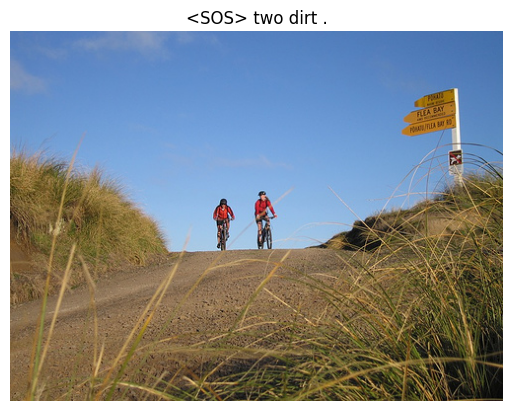

In [ ]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(232, antialias=True),
        transforms.CenterCrop(224),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                            std=[0.229, 0.224, 0.225])
        ])
with torch.no_grad():
    idx = random.randint(0, len(images))
    image_path = images[2]
    image = cv2.imread(image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_input = transform(image).unsqueeze(0).to(device)
    caption = model.generate_caption(image_input, beam_k=10)

    plot_result(image, caption)